In [1]:
# -----------------------------------------------------------------------------------------------------------------------
# Run Tybalt on Pa dataset
#
# Alexandra Lee 
# 21 June 2018
# --------------------------------------------------------------------------------------------------------------------
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
np.random.seed(123)

Using TensorFlow backend.


In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Files
# --------------------------------------------------------------------------------------------------------------------
data_file = 'C:/Users/alexj/Documents/UPenn/CGreene/Pseudomonas/data/all-pseudomonas-gene-normalized.pcl'
rnaseq = pd.read_table(data_file,sep='\t',index_col=0)
rnaseq = rnaseq.transpose()

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Initialize hyper parameters
#
# learning rate: 
# batch size: Total number of training examples present in a single batch
#             Iterations is the number of batches needed to complete one epoch
# epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
# kappa: warmup
# original dim: dimensions of the raw data
# latent dim: dimensiosn of the latent space (fixed by the user)
#   Note: intrinsic latent space dimension unknown
# epsilon std: 
# beta: Threshold value for ReLU?
# --------------------------------------------------------------------------------------------------------------------

learning_rate = 0.001
batch_size = 50
epochs = 100
kappa = 0.01

original_dim = rnaseq.shape[1]
intermediate_dim = 100
latent_dim = 10
epsilon_std = 1.0
beta = K.variable(0)

stat_file = 'C:/Users/alexj/Documents/UPenn/CGreene/Pseudomonas/stats/tybalt_1layer'+str(latent_dim)+'_stats.csv'
hist_plot_file ='C:/Users/alexj/Documents/UPenn/CGreene/Pseudomonas/stats/tybalt_1layer'+str(latent_dim)+'hist.png'
encoded_file ='C:/Users/alexj/Documents/UPenn/CGreene/Pseudomonas/models/tybalt_1layer_encoded_'+str(latent_dim)+'.tsv'

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Functions
#
# Based on publication by Greg et. al. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5728678/
# https://github.com/greenelab/tybalt/blob/master/scripts/vae_pancancer.py
# --------------------------------------------------------------------------------------------------------------------

# Function for reparameterization trick to make model differentiable
def sampling(args):

    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)

    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * \
                              metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded -
                                K.square(z_mean_encoded) -
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [5]:
# --------------------------------------------------------------------------------------------------------------------
# Data initalizations
# --------------------------------------------------------------------------------------------------------------------

# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq.drop(rnaseq_test_df.index)

# Create a placeholder for an encoded (original-dimensional)
rnaseq_input = Input(shape=(original_dim, ))

In [6]:
# --------------------------------------------------------------------------------------------------------------------
# Architecture of VAE
# --------------------------------------------------------------------------------------------------------------------

# ENCODER

# Input layer is compressed into a mean and log variance vector of size
# `latent_dim`. Each layer is initialized with glorot uniform weights and each
# step (dense connections, batch norm,and relu activation) are funneled
# separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

# "z_mean_dense_linear" is the encoded representation of the input
#    Take as input arrays of shape (*, original dim) and output arrays of shape (*, latent dim)
#    Combine input from previous layer using linear summ
# Normalize the activations (combined weighted nodes of the previous layer)
#   Transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
# Apply ReLU activation function to combine weighted nodes from previous layer
#   relu = threshold cutoff (cutoff value will be learned)
#   ReLU function filters noise

# X is encoded using Q(z|X) to yield mu(X), sigma(X) that describes latent space distribution
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# Customized layer
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
#
# sampling():
# randomly sample similar points z from the latent normal distribution that is assumed to generate the data,
# via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor
# z ~ Q(z|X)
# Note: there is a trick to reparameterize to standard normal distribution so that the space is differentiable and 
# therefore gradient descent can be used
#
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
z = Lambda(sampling,
           output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])


# DECODER

# The decoding layer is much simpler with a single layer glorot uniform
# initialized and sigmoid activation
# Reconstruct P(X|z)
decoder_to_reconstruct = Dense(original_dim,
                               kernel_initializer='glorot_uniform',
                               activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)


# CONNECTIONS
# fully-connected network
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


C:\Users\alexj\AppData\Local\conda\conda\envs\Pa\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [7]:
# --------------------------------------------------------------------------------------------------------------------
# Training
# --------------------------------------------------------------------------------------------------------------------

# fit Model
# hist: record of the training loss at each epoch
hist = vae.fit(np.array(rnaseq_train_df), shuffle=True, epochs=epochs, batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa)])

Train on 1072 samples, validate on 119 samples
Epoch 1/100
1072/1072 [==============================] - 1s 1ms/step - loss: 3812.7565 - val_loss: 3760.8546
Epoch 2/100
1072/1072 [==============================] - 1s 567us/step - loss: 3729.0367 - val_loss: 3691.6638
Epoch 3/100
1072/1072 [==============================] - 1s 552us/step - loss: 3670.6788 - val_loss: 3677.3672
Epoch 4/100
1072/1072 [==============================] - 1s 540us/step - loss: 3622.2727 - val_loss: 3628.7030
Epoch 5/100
1072/1072 [==============================] - 1s 484us/step - loss: 3588.8914 - val_loss: 3586.8926
Epoch 6/100
1072/1072 [==============================] - 1s 709us/step - loss: 3569.3799 - val_loss: 3591.0278
Epoch 7/100
1072/1072 [==============================] - 1s 724us/step - loss: 3542.5957 - val_loss: 3617.7612
Epoch 8/100
1072/1072 [==============================] - 1s 501us/step - loss: 3533.8719 - val_loss: 3537.8909
Epoch 9/100
1072/1072 [==============================] - 1s 484us/s

Epoch 74/100
1072/1072 [==============================] - 1s 580us/step - loss: 3399.8633 - val_loss: 3418.6447
Epoch 75/100
1072/1072 [==============================] - 1s 518us/step - loss: 3399.4645 - val_loss: 3417.8789
Epoch 76/100
1072/1072 [==============================] - 1s 543us/step - loss: 3400.9705 - val_loss: 3424.9216
Epoch 77/100
1072/1072 [==============================] - 0s 464us/step - loss: 3398.3183 - val_loss: 3422.5690
Epoch 78/100
1072/1072 [==============================] - 1s 504us/step - loss: 3399.0416 - val_loss: 3418.6666
Epoch 79/100
1072/1072 [==============================] - 1s 533us/step - loss: 3398.2116 - val_loss: 3413.9653
Epoch 80/100
1072/1072 [==============================] - 1s 530us/step - loss: 3397.4418 - val_loss: 3412.8165
Epoch 81/100
1072/1072 [==============================] - 1s 603us/step - loss: 3398.7511 - val_loss: 3411.9232
Epoch 82/100
1072/1072 [==============================] - 1s 498us/step - loss: 3398.4869 - val_loss: 34

In [8]:
# --------------------------------------------------------------------------------------------------------------------
# Use trained model to make predictions
# --------------------------------------------------------------------------------------------------------------------
encoder = Model(rnaseq_input, z_mean_encoded)

encoded_rnaseq_df = encoder.predict_on_batch(rnaseq)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1

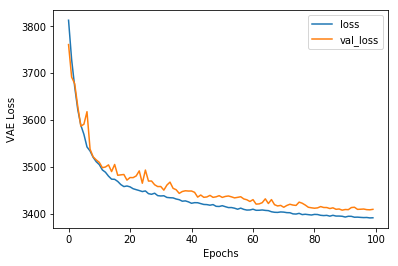

In [9]:
# --------------------------------------------------------------------------------------------------------------------
# Visualize training performance
# --------------------------------------------------------------------------------------------------------------------
history_df = pd.DataFrame(hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [10]:
# --------------------------------------------------------------------------------------------------------------------
# Output
# --------------------------------------------------------------------------------------------------------------------

# Save training performance
history_df = pd.DataFrame(hist.history)
history_df = history_df.assign(learning_rate=learning_rate)
history_df = history_df.assign(batch_size=batch_size)
history_df = history_df.assign(epochs=epochs)
history_df = history_df.assign(kappa=kappa)
history_df.to_csv(stat_file, sep='\t')

# Save latent space representation
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')